Data from https://www.ssa.gov/OACT/babynames/limits.html

National Data on the relative frequency of given names in the population of U.S. births where the individual has a Social Security Number (Tabulated based on Social Security records as of March 4, 2018)

For each year of birth YYYY after 1879, we created a comma-delimited file called yobYYYY.txt. Each record in the individual annual files has the format "name,sex,number," where name is 2 to 15 characters, sex is M (male) or F (female) and "number" is the number of occurrences of the name. Each file is sorted first on sex and then on number of occurrences in descending order. When there is a tie on the number of occurrences, names are listed in alphabetical order. This sorting makes it easy to determine a name's rank. The first record for each sex has rank 1, the second record for each sex has rank 2, and so forth.

To safeguard privacy, we restrict our list of names to those with at least 5 occurrences.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import pandas as pd

# add src folder to path, and auto-reload it when it changes
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
import util


In [2]:

data_folder = os.path.abspath(os.path.join('..','..','big_datasets','first_names_data','names'))
col_names = ['name','gender','count']
df = util.load_stitch_files(data_folder, col_names, 'txt')
df.sample(5)


,name,gender,count,year
1070969,Jenessa,F,116,1990
1651538,Raife,M,10,2009
377882,Marieann,F,12,1941
900951,Amari,M,6,1981
564349,De,F,12,1959


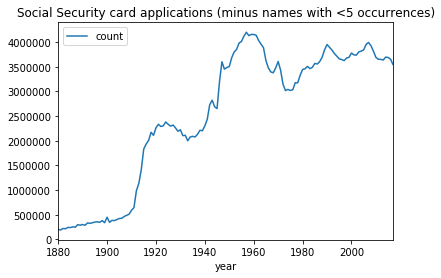

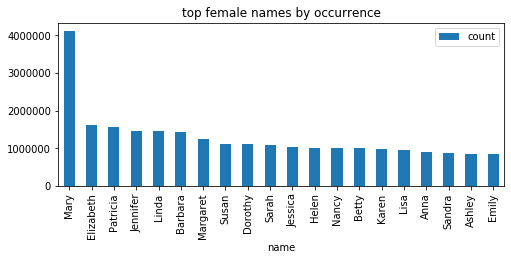

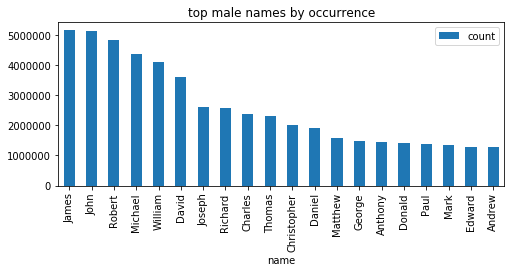

In [3]:
(
    df.groupby('year')
    .agg({'count':'sum'})
    .plot(title='Social Security card applications (minus names with <5 occurrences)')
)

(
    df[(df["gender"]=="F") & (df['year']>=1500)]
    .groupby('name', as_index=False)
    .agg({"count": "sum"})
    .sort_values("count",ascending=False)
    .reset_index(drop=True)
    .nlargest(20,'count')
    .plot(kind='bar',x='name',y='count', title='top female names by occurrence', figsize=(8,3))
)

(
    df[(df["gender"]=="M") & (df['year']>=1500)]
    .groupby('name', as_index=False)
    .agg({"count": "sum"})
    .sort_values("count",ascending=False)
    .reset_index(drop=True)
    .nlargest(20,'count')
    .plot(kind='bar',x='name',y='count', title='top male names by occurrence', figsize=(8,3))
)



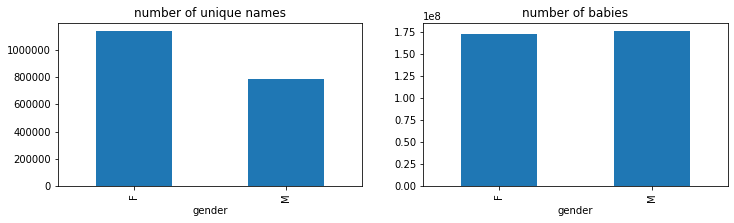

In [4]:
plt.subplot(1, 2, 1)
df.groupby('gender')['gender'].count().plot.bar(figsize=(12,3),title='number of unique names')
plt.subplot(1, 2, 2)
df.groupby('gender')['count'].sum().plot.bar(title='number of babies')


In [5]:
def androgynous_names():
    # what are the top names that are both male and female?
    # TODO: do this in a single pass and chained
    f = df[df['gender']=='F'].groupby('name').agg({'count':'sum'}).reset_index().rename(columns={'count': 'countf'})
    m = df[df['gender']=='M'].groupby('name').agg({'count':'sum'}).reset_index().rename(columns={'count': 'countm'})
    b = pd.merge(f,m, how='inner', on='name')
    b.fillna(0, inplace=True)
    b['count_hmu'] = round(1/(1/b['countf']+1/b['countm'])) # harmonic mean
    b['pct_f'] = b['countf']/(b['countf']+b['countm'])
    return b.sort_values('count_hmu',ascending=False).head(10)
androgynous_names()

,name,countf,countm,count_hmu,pct_f
10340,Willie,146148,448702,110241.0,0.245689
4917,Jordan,130158,369745,96269.0,0.260367
9618,Taylor,317936,109852,81643.0,0.743209
6274,Leslie,266474,112689,79197.0,0.702795
9715,Terry,96883,422580,78814.0,0.186506
5496,Kelly,471024,81550,69515.0,0.852418
524,Angel,94837,226719,66867.0,0.294932
4760,Jessie,167010,110027,66329.0,0.602844
4411,Jamie,267599,85299,64681.0,0.758290
287,Alexis,336623,62928,53017.0,0.842503


In [6]:
# plot total counts over time for multiple names at once

def get_name_plotter():
    # aggregate df only once (expensive), and return a generic name plotter 
    # then use plotter(['Tom','Kim']) to plot their counts by year
    d = df.groupby(['name','year']).agg({'count':'sum'}).reset_index()
    def plotter(names,min_year=1800):
        ax = (
            d.query("name in {} and year>={}".format(str(names),min_year))
            .pivot(index='year', columns='name', values='count')
            .plot()
        )
    return plotter
plotter = get_name_plotter()


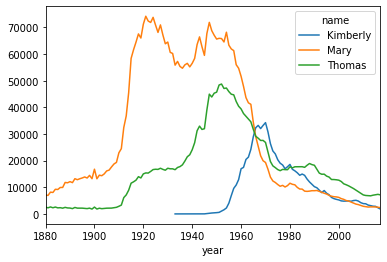

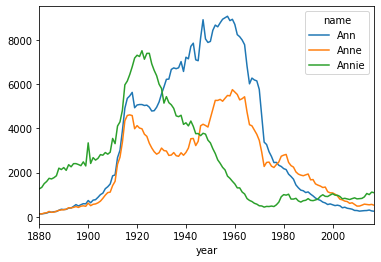

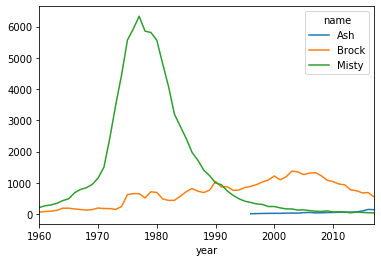

In [7]:
plotter(['Thomas','Kimberly', 'Mary'])
plotter(['Ann','Anne','Annie'])
plotter(['Brock','Ash','Misty'],1960)

In [8]:
# proportion of top male names before 1900
d = df[(df['gender']=='M') & (df['year']<=1900)].groupby('name')[['count']].sum()
d['prop'] = d.apply(lambda x:x/x.sum()).rename({'count':'prop'}, axis=1)
d.sort_values('prop',ascending=False).head()


,count,prop
name,,
John,180444,0.075599
William,165704,0.069424
James,112025,0.046934
George,96412,0.040393
Charles,87603,0.036702


In [9]:

def get_name_prop_plotter():
    # aggregate df only once (expensive), and return a generic name plotter 
    # then use plotter(['Tom','Kim']) to plot their proportions by year
    name_years = df.groupby(['name','year']).agg({'count':'sum'})
    years = name_years.groupby(['year']).agg({'count':'sum'})
    dv = name_years.div(years).rename({'count':'prop'}, axis=1).reset_index()
    def plotter(names,min_year=1800):
        return (
            dv.query("name in {} and year>={}".format(str(names),1800))
            .pivot(index='year', columns='name', values='prop')
            .plot()
        )
    return plotter
plotter = get_name_prop_plotter()

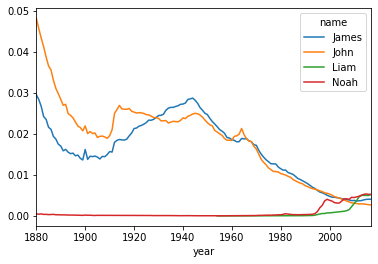

In [10]:
# % of male babies called john or james, over time
plotter(['John','James','Liam','Noah'])
